# Joining datasets

## This notebook demonstrates loading individual datasets and joining them into combined datasets.

In [1]:
from matplotlib import pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
import numpy as np

from ecogdata.datasource import MappedSource, PlainArraySource
from ecogdata.devices.data_util import load_experiment_auto, join_datasets, load_datasets

from ecogdata.expconfig import available_sessions, session_info, session_conf

from ecogdata.devices.load.file2data import FileLoader

In [4]:
# Get an arbitrary set of tone-stimulated recordings from an awake recording session
session = available_sessions('16017')[1]
info = session_conf(session)

recordings = []
for key in info:
    if 'tones_tab' not in info[key]:
        continue
    if info[key].tones_tab.endswith('txt'):
        recordings.append(key)
print(recordings)

['2016-09-26_15-49-32_002', '2016-09-26_16-02-50_004', '2016-09-26_16-09-55_005', '2016-09-26_16-17-23_006', '2016-09-26_16-23-07_007', '2016-09-26_16-48-13_009']


## Experiment recording loading from session config "database"

In [5]:
help(load_experiment_auto)

Help on function load_experiment_auto in module ecogdata.devices.data_util:

load_experiment_auto(session, test, **load_kwargs)
    Loads a recording from the session database system. Hardware and
    multiple other parameters are interpreted/parsed from the database 
    config file. Any arguments specified in load_kwargs take precedence
    and must be literal (e.g. already parsed).
    
    Parameters
    ----------
    
    session: str
        Name of recording session in 'group/session-name' syntax
    test: str
        Base name (no extension) of recording. If this is also a section
        in the config file, then further information is taken from that
        section.
    
    Returns
    -------
    dataset: ElectrodeDataSource



## Load arguments

The `load_experiment_auto` method delegates loading to specific data-wrangling code for each acquisition system. See modules in `ecogdata.devices.load...`. There are different arguments for each system. Most loaders implement a form of the `ecogdata.devices.load.file2data.FileLoader` class (see doc below). *This is an ongoing migration.*

Some load arguments are specified in `info.session`, and some may be over-ridden in the recording subsections.

Final priority is given to load arguments specified at runtime.

In [6]:
# Using mapped='r+' to ensure read-write access -- this will create a temp file.
dataset = load_experiment_auto(session, recordings[0], mapped='r+')

Calling super to map/load /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_15-49-32_002_Fs2000.h5 in mode r scaling units 1.0
Opening source file /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_15-49-32_002_Fs2000.h5 in mode r
Creating mapped sources: downsample ratio 1
Creating writeable mirrored sources with copy mode: all


This dataset has mapped sources (primary is `data`). The other timeseries (`adc` and `aux`) are actually just references to the `aligned_arrays` from the primary `MappedSource`.

In [7]:
print(dataset)
print()
aligned_arrays = [k + ': ' + str(getattr(dataset.data, k)) for k in dataset.data.aligned_arrays]
print('Aligned arrays tracked by dataset.data:')
print('\n'.join(aligned_arrays))

data              : <class 'ecogdata.datasource.memmap.MappedSource'>                   
adc               : <class 'ecogdata.datasource.array_abstractions.HDF5Buffer'>         
aux               : <class 'ecogdata.datasource.array_abstractions.HDF5Buffer'>         
chan_map          : <class 'ecogdata.channel_map.ChannelMap'>                           
Fs                : <class 'float'>                                                     
pos_edge          : <class 'numpy.ndarray'>                                             
trig_chan         : <class 'numpy.ndarray'>                                             
bandpass          : <class 'NoneType'>                                                  
notches           : <class 'NoneType'>                                                  
units             : <class 'str'>                                                       
transient_snipped : <class 'bool'>                                                      
ground_chans      : <

## Simple datasource joining

Data sources (either mapped or loaded) can be joined with `source.join()`.

In [8]:
dataset2 = load_experiment_auto(session, recordings[1], mapped='r+')

Calling super to map/load /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_16-02-50_004_Fs2000.h5 in mode r scaling units 1.0
Opening source file /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_16-02-50_004_Fs2000.h5 in mode r
Creating mapped sources: downsample ratio 1
Creating writeable mirrored sources with copy mode: all


The joined set is the simple concatenation of the two sets (with all the aligned arrays appended as well).

In [9]:
joined_dataset = dataset.data.join(dataset2.data)
print(dataset.data.shape, '+', dataset2.data.shape, '=', joined_dataset.shape)

(61, 843162) + (61, 839373) = (61, 1682535)


Under the hood, the memory mapping for the two single recording sources is a plain `HDF5Buffer` that mediates smart read/write interfacing with the mapped data file.

In [10]:
type(dataset.data.data_buffer)

ecogdata.datasource.array_abstractions.HDF5Buffer

The buffer for the joined dataset is a `BufferBinder`. This object does not create a new mapped file, but binds multiple source files together into a single source. This is done by managing hand-offs when indexing between sources.

In [11]:
type(joined_dataset.data_buffer)

ecogdata.datasource.array_abstractions.BufferBinder

<IPython.core.display.Javascript object>


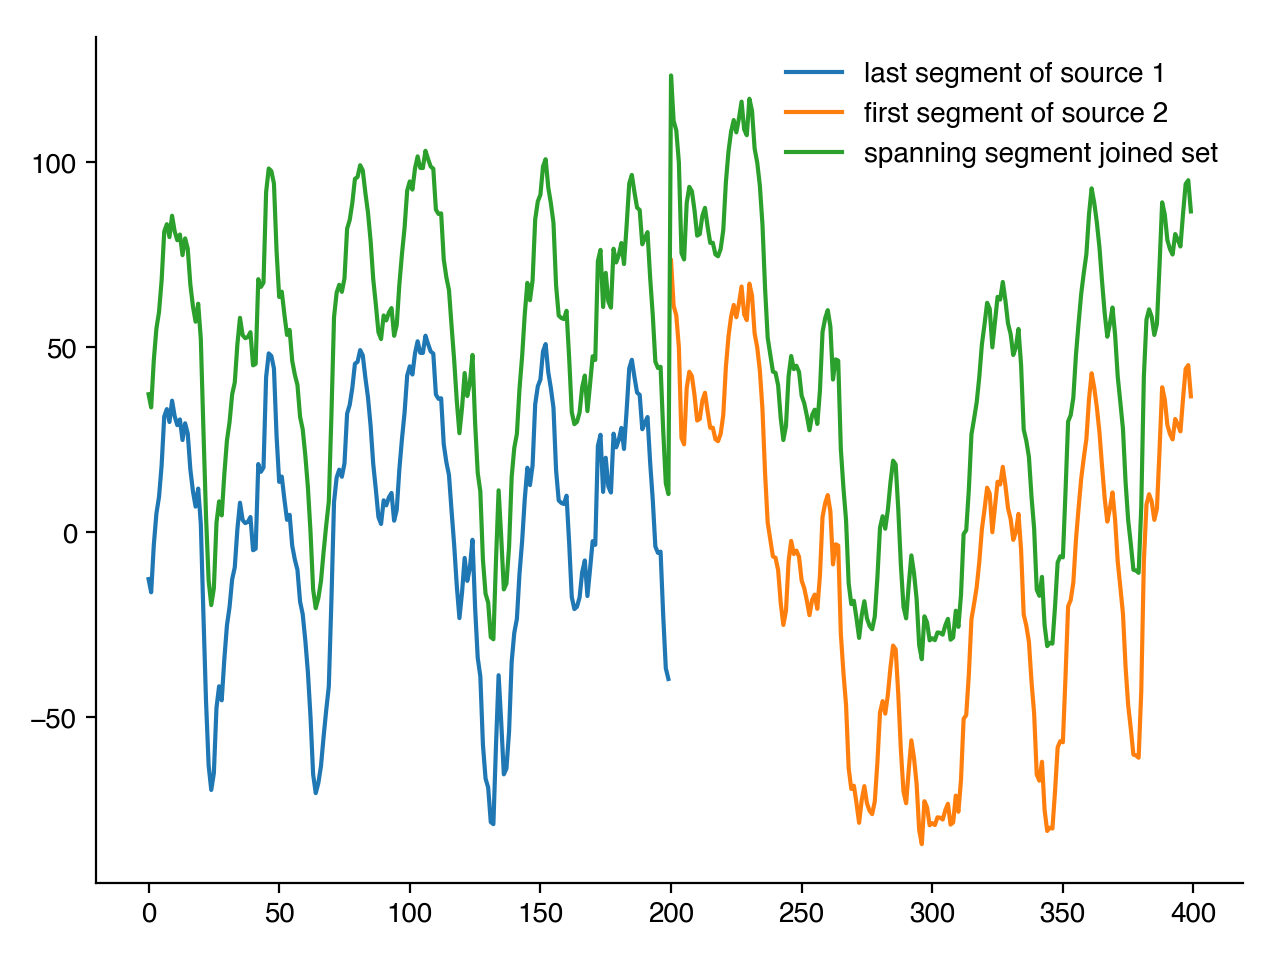

In [12]:
plt.figure()
plt.plot(np.arange(200), dataset.data[0, -200:], label='last segment of source 1')
plt.plot(np.arange(200, 400), dataset2.data[0, :200], label='first segment of source 2')
t1 = dataset.data.shape[1]
# BufferBinder can slice thru the two sets using hand-off
plt.plot(np.arange(400), joined_dataset[0, t1 - 200:t1 + 200] + 50, label='spanning segment joined set')
plt.legend()
plt.tight_layout()

## Joining recording datasets
The mapped datasources are easily joined. But metadata like channel maps, sampling rate, and stimulation event timestamps need to be joined as well. Use `ecogdata.devices.data_util.join_datasets` for this.

In [13]:
help(join_datasets)

Help on function join_datasets in module ecogdata.devices.data_util:

join_datasets(all_sets, popdata=True, shared_mem=True, source_type='')
    Append multiple pre-loaded datasets end-to-end to form a single set.
    If StimulatedExperiments are associated with these sets,
    then also join those experiments to reflect the union of all
    conditions presented. If channel maps differ between datasets, only
    the intersection of all channels is retained in the joined set. Note for
    joining mapped datasources, the underlying data layout (i.e. channel order) of
    each dataset needs to match. However, channel order permutation is supported
    with source_type='loaded'. Original dataset Bunches may be modified in
    this method.
    
    Parameters
    ----------
    all_sets: Sequence
        Sequene of dataset Bunches
    popdata: bool
        Pop each datasets data array from original Bunch (may reduce memory consumption)
    shared_mem: bool
        Combine data into a shared

### join_datasets() only combines channels that are unmasked for each recording

In [14]:
# Apply channel masking to demonstrate map intersecting
mask = dataset.data.binary_channel_mask
mask[:10] = False
dataset.data.set_channel_mask(mask)
dataset.chan_map = dataset.chan_map.subset(mask)
joined_set = join_datasets([dataset, dataset2])

In [15]:
joined_set

data              : <class 'ecogdata.datasource.memmap.MappedSource'>                   
adc               : <class 'ecogdata.datasource.array_abstractions.BufferBinder'>       
aux               : <class 'ecogdata.datasource.array_abstractions.BufferBinder'>       
name              : <class 'str'>                                                       
exp               : <class 'ecogdata.expconfig.exp_descr.base_exp.StimulatedExperiment'>
pos_edge          : <class 'numpy.ndarray'>                                             
chan_map          : <class 'ecogdata.channel_map.ChannelMap'>                           
Fs                : <class 'float'>                                                     
trig_chan         : <class 'numpy.ndarray'>                                             
bandpass          : <class 'NoneType'>                                                  
notches           : <class 'NoneType'>                                                  
units             : <

Check the lengths of relevant arrays

In [16]:
shapes = [joined_set[attr].shape for attr in ['data', 'adc', 'aux', 'pos_edge']]
shapes.append(len(joined_set.exp))
print(shapes)

[(51, 1682535), (8, 1682535), (3, 1682535), (780,), 780]


<IPython.core.display.Javascript object>


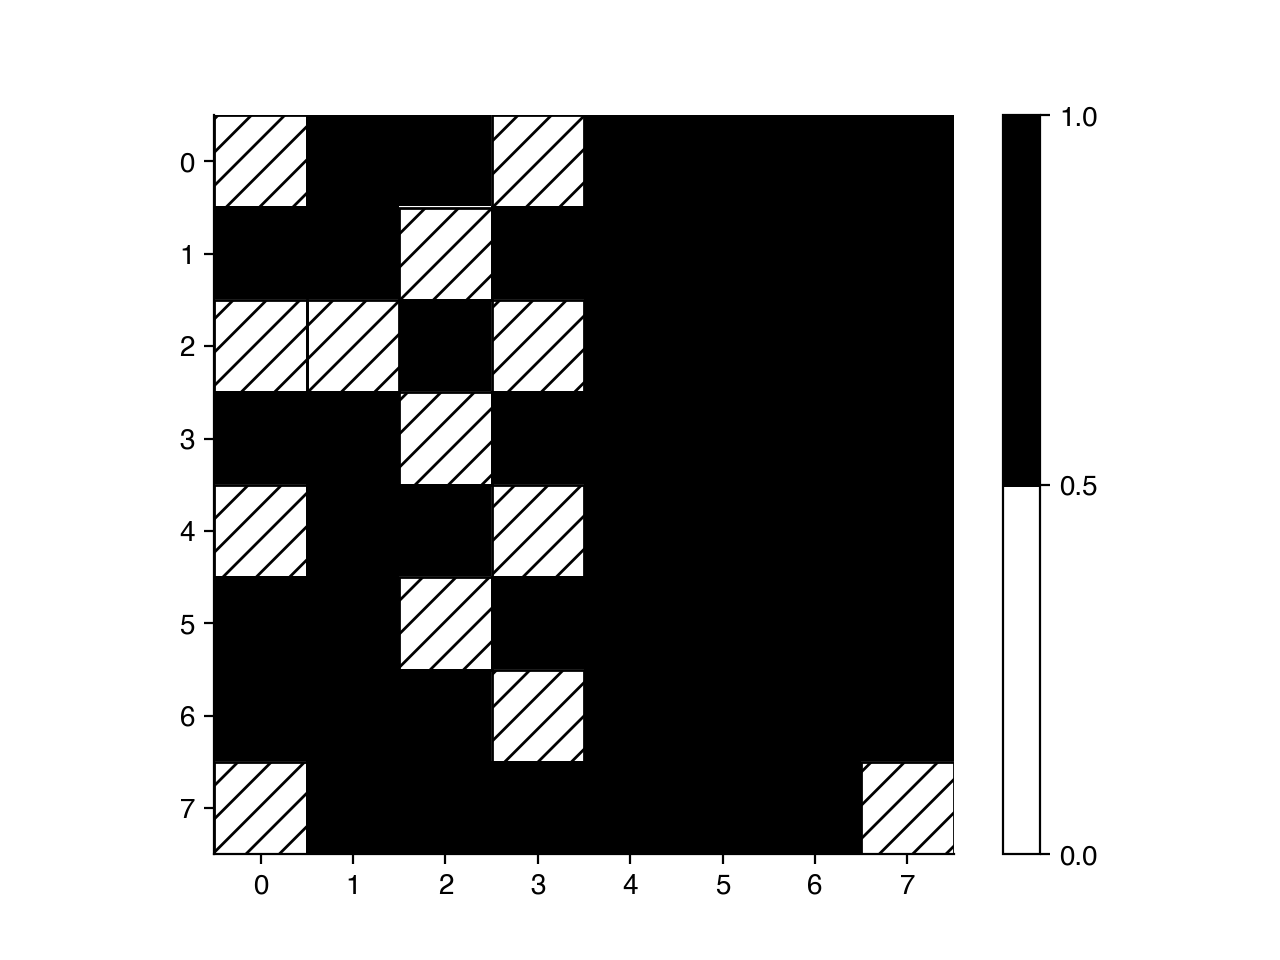

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1116354e0>)

In [17]:
joined_set.chan_map.image()

## Use load_datasets to load multiple recordings at the same time

In [18]:
full_dataset = load_datasets(session, recordings[:4], load_kwargs=dict(mapped='r+'))

Calling super to map/load /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_15-49-32_002_Fs2000.h5 in mode r scaling units 1.0
Opening source file /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_15-49-32_002_Fs2000.h5 in mode r
Creating mapped sources: downsample ratio 1
Creating writeable mirrored sources with copy mode: all
Calling super to map/load /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_16-02-50_004_Fs2000.h5 in mode r scaling units 1.0
Opening source file /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_16-02-50_004_Fs2000.h5 in mode r
Creating mapped sources: downsample ratio 1
Creating writeable mirrored sources with copy mode: all
Calling super to map/load /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_16-09-55_005_Fs2000.h5 in mode r scaling units 1.0
Opening source file /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_16-09-55_00

In [19]:
print(full_dataset)
print()
print('----- Other info -----')
print('Dataset name (joined names):', full_dataset.name)
print('Data shape:', full_dataset.data.shape)
print('Number of tones:', len(full_dataset.exp))

data              : <class 'ecogdata.datasource.memmap.MappedSource'>                   
adc               : <class 'ecogdata.datasource.array_abstractions.BufferBinder'>       
aux               : <class 'ecogdata.datasource.array_abstractions.BufferBinder'>       
name              : <class 'str'>                                                       
exp               : <class 'ecogdata.expconfig.exp_descr.base_exp.StimulatedExperiment'>
pos_edge          : <class 'numpy.ndarray'>                                             
chan_map          : <class 'ecogdata.channel_map.ChannelMap'>                           
Fs                : <class 'float'>                                                     
trig_chan         : <class 'numpy.ndarray'>                                             
bandpass          : <class 'NoneType'>                                                  
notches           : <class 'NoneType'>                                                  
units             : <

## Other join options

Load the joined set to memory (from mapped)

In [20]:
# join_datasets potentially modifies input -- reset the channel mask on second data source 
dataset2.data.set_channel_mask(None)
joined_set = join_datasets([dataset, dataset2], source_type='loaded', popdata=False)

In [21]:
joined_set

data              : <class 'ecogdata.datasource.basic.PlainArraySource'>                
adc               : <class 'numpy.ndarray'>                                             
aux               : <class 'numpy.ndarray'>                                             
name              : <class 'str'>                                                       
exp               : <class 'ecogdata.expconfig.exp_descr.base_exp.StimulatedExperiment'>
pos_edge          : <class 'numpy.ndarray'>                                             
chan_map          : <class 'ecogdata.channel_map.ChannelMap'>                           
Fs                : <class 'float'>                                                     
trig_chan         : <class 'numpy.ndarray'>                                             
bandpass          : <class 'NoneType'>                                                  
notches           : <class 'NoneType'>                                                  
units             : <

In [22]:
shapes = [joined_set[attr].shape for attr in ['data', 'adc', 'aux', 'pos_edge']]
shapes.append(len(joined_set.exp))
print(shapes)

[(51, 1682535), (8, 1682535), (3, 1682535), (780,), 780]


Join from a mixture of loaded and mapped sources and put the result into a `MappedSource`

In [23]:
dataset2 = load_experiment_auto(session, recordings[1], mapped=False)

Calling super to map/load /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_16-02-50_004_Fs2000.h5 in mode r scaling units 1.0
Opening source file /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_16-02-50_004_Fs2000.h5 in mode r
Creating mapped sources: downsample ratio 1
Creating writeable mirrored sources with copy mode: all


In [24]:
joined_set = join_datasets([dataset, dataset2], source_type='mapped')
joined_set

data              : <class 'ecogdata.datasource.memmap.MappedSource'>                   
adc               : <class 'ecogdata.datasource.array_abstractions.BufferBinder'>       
aux               : <class 'ecogdata.datasource.array_abstractions.BufferBinder'>       
name              : <class 'str'>                                                       
exp               : <class 'ecogdata.expconfig.exp_descr.base_exp.StimulatedExperiment'>
pos_edge          : <class 'numpy.ndarray'>                                             
chan_map          : <class 'ecogdata.channel_map.ChannelMap'>                           
Fs                : <class 'float'>                                                     
trig_chan         : <class 'numpy.ndarray'>                                             
bandpass          : <class 'NoneType'>                                                  
notches           : <class 'NoneType'>                                                  
units             : <

In [25]:
shapes = [joined_set[attr].shape for attr in ['data', 'adc', 'aux', 'pos_edge']]
shapes.append(len(joined_set.exp))
print(shapes)

[(51, 1682535), (8, 1682535), (3, 1682535), (780,), 780]


Join from a mixture of loaded and mapped sources and load the result into a `PlainArraySource`

In [26]:
dataset2 = load_experiment_auto(session, recordings[1], mapped=False)
joined_set = join_datasets([dataset, dataset2], source_type='loaded')
joined_set

Calling super to map/load /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_16-02-50_004_Fs2000.h5 in mode r scaling units 1.0
Opening source file /Volumes/big-mama/recordings/Viventi 2016-09-26 P4 Rat 16017/2016-09-26_16-02-50_004_Fs2000.h5 in mode r
Creating mapped sources: downsample ratio 1
Creating writeable mirrored sources with copy mode: all


data              : <class 'ecogdata.datasource.basic.PlainArraySource'>                
adc               : <class 'numpy.ndarray'>                                             
aux               : <class 'numpy.ndarray'>                                             
name              : <class 'str'>                                                       
exp               : <class 'ecogdata.expconfig.exp_descr.base_exp.StimulatedExperiment'>
pos_edge          : <class 'numpy.ndarray'>                                             
chan_map          : <class 'ecogdata.channel_map.ChannelMap'>                           
Fs                : <class 'float'>                                                     
trig_chan         : <class 'numpy.ndarray'>                                             
bandpass          : <class 'NoneType'>                                                  
notches           : <class 'NoneType'>                                                  
units             : <

In [27]:
shapes = [joined_set[attr].shape for attr in ['data', 'adc', 'aux', 'pos_edge']]
shapes.append(len(joined_set.exp))
print(shapes)

[(51, 1682535), (8, 1682535), (3, 1682535), (780,), 780]
